# Presentation du projet

## TODO ⌚

# Import de bibliothèques 📚

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

import os
import re

from math import log2
import numpy as np
import scipy.stats as stats
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn

# Fonctions ⚙️

In [2]:
def plot_histo(data, title=None, xlabel=None, drop_outliers=False, bins='sturges', plot_density=True):
    if drop_outliers:
        data = data[data.between(data.quantile(drop_outliers), data.quantile(1 - drop_outliers))]
    if bins == 'sturges':
        bins = int(1+log2(len(data)))
#     mu = data.mean()
#     sigma = data.std()
#     x_norm = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#     plt.plot(x_norm, stats.norm.pdf(x_norm, mu, sigma), label="Gaussienne de l'échantillon")
    plt.style.use("seaborn")
    if plot_density:
        density = gaussian_kde(data)
        xs = np.linspace(data.min(),data.max(),200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs), label="Courbe de densité")
    plt.ylabel("frequency")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.hist(data, bins=bins, density=True)
    plt.legend()
    plt.show()

In [3]:
def split_custom(label_string, delimiter=','):
    """Cette fonction prend en argument une chaine de caractères et retourne une liste"""
    return label_string.split(delimiter)

In [4]:
def get_unique_elements(panda_serie):
    """This functions returns the list of unique elements 
    out of a panda serie of strings with comma separated elements"""
    all_labels = set()
    for labels in panda_serie.map(split_custom):
        for label in labels:
            all_labels.add(label)
    return list(all_labels)

<a id='fonctionbio'></a>

In [5]:
def test_bio(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'organic' in label or 'bio' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backbio)

<a id='fonctionvege'></a>

In [6]:
def test_vege(labels):
    """From a list of labels this function returns a booleean if 'organic' or 'bio' is in one of the labels"""
    bool_test = False
    for label in labels:
        label = label.lower()
        if 'vegetarian' in label or 'vegan' in label:
            bool_test = True
            break
    return bool_test

Retour au [script](#backvege)

<a id='fonctionnegation'></a>

In [7]:
# This function works but would be more efficient if it would detect the language. We'll save that for later
def test_no_something(labels, dict_something):
    """From a list of labels this function returns a booleean if 'preserative' and a negation is in one of the labels"""
    for word, negations in dict_something.items():
        for label in labels:
            label = label.lower()
            bool_list = []
            #looking for word preservative
            preservative_in_label = word in label
            if preservative_in_label:
                #looking for negation
                for negation in negations:
                    if negation in label:
                        return True

    return False

In [3]:
import re
bool(re.compile(r'\b{}.*\b'.format('color'), flags=re.IGNORECASE).search('il y a des colorants'))

True

\bcorante.*\b

\bno\b

In [9]:
bool(re.match(r'\b{0}*\b'.format('color'), 'colorants'))

False

In [10]:
bool(re.compile(r'\b{0}*\b'.format('corante'), flags=re.IGNORECASE).search('corantes'))

False

- Retour au [script](#backconserv) Conservateurs
- Retour au [script](#backcolor) Colorants
- Retour au [script](#backGMO) OGMs

# Données 🎁

In [11]:
data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t')

C:\Users\S053567\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,12,26,27,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
data.shape

(1524579, 183)

In [13]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

# Profiling 🔍

Etant données les dimensions de ce dataset, je vais réaliser l'analyse préliminaire avec Pandas Profiling. L'analyse est exportée en HTML pour une meilleure lisibilité du NB

In [14]:
# profile = ProfileReport(data, title="Report on OpenFoodFacts", minimal=True)

In [15]:
# profile.to_file('profile_report.html')

Voir le report : [cliquer ici](profile_report.html)

# Idee : 💡
### A partir d'un produit, proposer des produits similaires ayant un emballage meilleur. Appuyer l'analyse par des etudes sur le lien entre l'emballage plastique et les mauvaises caractéristiques nutritionnelles.
## Mieux manger serait-il lié à l'emballage?

Afin de vérifier la faisibilité de cette étude, nous allons déterminer les features necessaires, filtrer les NAN et regarder la taille du dataset filtré

In [16]:
col_necessaires = ['labels_en', 'saturated-fat_100g', 'categories_en', 
                   'packaging_tags', 'additives_n', 'ingredients_from_palm_oil_n', 
                   'nutriscore_score', 'nutriscore_grade', 'pnns_groups_2']
# TODO : REMPLACER CATEGORIES PAR pnns-goups

In [17]:
data_filtre = data.dropna(subset=col_necessaires)

In [18]:
data_filtre.shape

(92328, 183)

Cette quantité a l'air suffisante à première vue

# Nettoyage 🧼

Les colonnes suivantes necessitent une attention particulière du fait de leur forte cardinalité:
- [Labels](#nett_1)
- [Categories](#nett_2)
- [Packaging](#nett_3)

<a id='nett_1'></a>
### Labels 🏷️

In [19]:
data_filtre.labels_en.describe()

count         92328
unique        31719
top       Green Dot
freq           5153
Name: labels_en, dtype: object

Cette variable a une forte cardinalité et est qualitative. Regardons les instances les plus fréquentes

In [20]:
data_filtre.labels_en.value_counts().head(10)

Green Dot                                       5153
Made in France                                  2218
Gluten-free                                     1605
Vegetarian,Vegan                                1513
Organic,EU Organic,AB Agriculture Biologique    1277
Organic                                         1189
No preservatives                                1171
Green Dot,Made in France                         782
Made in Germany                                  702
Vegetarian                                       697
Name: labels_en, dtype: int64

On voit que les données sont souvent séparées par des virgules et que beaucoup de labels se répétent

In [21]:
labels_unique = get_unique_elements(data_filtre.labels_en)
len(labels_unique)

9611

Grâce à ce traitement, on obtient la cardinalité réelle mais c'est toujours trop

Dans l'idéal, pour cette étude, j'aimerais pouvoir séparer les labels avec ces grandes catégories suivantes:

In [22]:
labels_simple = ['organic', 'vegetarian_or_vegan', 'no_preservatives', 'no_colorings', 'sustainable', 'no_gmos', 'no_artificial_flavors']

Je vais partir sur une approche "Dummy" pour faciliter les filtrages. En effet je ne peux résumer un produit à un seul label.

<a id='backbio'></a>

Gestion du Bio (accès à la fonction [ici](#fonctionbio))

In [23]:
data_filtre.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

In [24]:
data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)

<ipython-input-24-1c4cc4edf2d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_organic'] = data_filtre['labels_en'].map(split_custom).map(test_bio)


<a id='backvege'></a>

Gestion du Végétarien (accès à la fonction [ici](#fonctionvege))

In [25]:
data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)

<ipython-input-25-1be3452212da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_vege_or_vegan'] = data_filtre.labels_en.map(split_custom).map(test_vege)


<a id='backconserv'></a>

Gestion des conservateurs (accès à la fonction [ici](#fonctionnegation))

In [26]:
preserv = []
for label in labels_unique:
    label = label.lower()
    if 'konser' in label:
        preserv.append(label)

In [27]:
# preserv

In [28]:
negations_english = ["no", "free", "without", '0', 'non']
negations_french = ["pas", "sans", "0", "aucun"]
negations_spanish= ['no', 'sin', 'zero', '0', 'libre', 'cero']
negations_portuguese = ['sem', 'nao']
negations_germanique = ['nie', 'bez', 'ohne', 'frei', 'utan', 'brez', 'keine']
dict_conservateur = {"conservateur": negations_french, "preservative": negations_english, 
                     'conservante':negations_spanish + negations_portuguese, 'konser': negations_germanique}

In [29]:
data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)

<ipython-input-29-7ecc0dafc191>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_preserv_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_conservateur)


In [30]:
data_filtre['is_labeled_preserv_free'].value_counts()

False    82838
True      9490
Name: is_labeled_preserv_free, dtype: int64

<a id='backcolor'></a>

Gestion des Colorants (accès à la fonction [ici](#fonctionnegation))

In [31]:
color = []
for label in labels_unique:
    label = label.lower()
    if 'color' in label:
        color.append(label)

In [32]:
# color

In [33]:
dict_colorant = {"color": negations_french + negations_english + negations_spanish + negations_portuguese, 'farb': negations_germanique}

In [34]:
data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)

<ipython-input-34-e97131e051d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_colorings_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_colorant)


In [35]:
data_filtre['is_labeled_colorings_free'].value_counts()

False    85021
True      7307
Name: is_labeled_colorings_free, dtype: int64

<a id='backGMO'></a>

Gestion des OGMs (accès à la fonction [ici](#fonctionnegation))

In [36]:
ogm = []
for label in labels_unique:
    label = label.lower()
    if 'gmo' in label:
        ogm.append(label)

In [37]:
# ogm

In [38]:
dict_ogm = {"ogm": negations_french + negations_portuguese, 'gmo': negations_english + negations_portuguese, 'gvo': negations_germanique}

In [39]:
data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)
# data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(lambda x : test_no_something(x, dict_ogm), axis=1) #essayer 

<ipython-input-39-aff1a4a9708c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtre['is_labeled_gmos_free'] = data_filtre.labels_en.map(split_custom).apply(test_no_something, dict_something=dict_ogm)


In [40]:
data_filtre['is_labeled_gmos_free'].value_counts()

False    90171
True      2157
Name: is_labeled_gmos_free, dtype: int64

<a id='nett_2'></a>
### Categories 🗂️

Je pensais d'abord utiliser les données categories_n. mais la données pnns_groups_2 est déjà travaillée et est renseignée à presque 100%

In [41]:
data_filtre['pnns_groups_2'].value_counts(normalize=True)

Biscuits and cakes                  0.089009
One-dish meals                      0.085565
unknown                             0.082099
Sweets                              0.056213
Processed meat                      0.055162
Cereals                             0.054707
Milk and yogurt                     0.052335
Cheese                              0.050700
Dressings and sauces                0.039923
Chocolate products                  0.032515
Fish and seafood                    0.029330
Bread                               0.026915
Vegetables                          0.026763
Salty and fatty products            0.024391
Meat                                0.024337
Breakfast cereals                   0.023503
Appetizers                          0.022962
Sweetened beverages                 0.022095
Fruit juices                        0.020135
Fruits                              0.017665
Dairy desserts                      0.016777
Fats                                0.016041
Ice cream 

In [42]:
data_filtre.loc[:,'pnns_groups_2'] = data_filtre.loc[:,'pnns_groups_2'].map(lambda x:x.lower()) #Inplace = true

C:\Users\S053567\Anaconda3\envs\env_OC_P03\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [43]:
data_filtre = data_filtre.replace('pizza pies and quiche', 'pizza pies and quiches')

TODO : Faire un KNN sur les données "Unknown" : 8.2% des données

<a id='nett_3'></a>
### Packaging 📦
Cette donnée essentielle à notre étude necessite un gros travail de traitement

In [44]:
data_filtre.packaging_tags.describe()

count                92328
unique               18443
top       sachet,plastique
freq                  4878
Name: packaging_tags, dtype: object

Même configuration : forte cardinalité d'une variable qualitative

In [45]:
data_filtre.packaging_tags.value_counts().head(50)

sachet,plastique               4878
plastique                      2626
kunststoff                     2017
carton                         1963
frais,plastique                1611
barquette,plastique            1460
frais                          1454
carton,plastique               1224
plastic                        1189
sachet                         1155
bouteille,plastique            1082
glas                           1077
bocal,verre                    1024
sachet-plastique                910
conserve                        804
plastico                        630
brique,carton                   614
bouteille,verre                 597
carton,boite,plastique          559
karton                          544
sachet,plastique,surgele        523
bocal,verre,couvercle,metal     518
barquette                       492
papier                          486
conserve,metal                  481
barquette,plastique,frais       477
brique                          464
bocal,verre,metal           

# Analyses Univariées
##### - [Labels](#univ_1)
##### - [Categories](#univ_2)
##### - [Packaging](#univ_3)
##### - [Additifs](#univ_4)
##### - [Huile de palme](#univ_5)
##### - [Graisse saturée](#univ_6)
##### - [Nutriscore numérique](#univ_7)
##### - [Nutriscore catégorique](#univ_8)

<a id='univ_1'></a>
### Labels 🚧🚧🚧

WORK IN PROGRESS
 -> Il serait difficle de faire une analyse en histogramme. Nous pourrions selectionner un label par exemple le label 'biologique', le rassembler avec les labels similaires et mener une analyse univariée d'une autre variable 

In [46]:
labels_to_inspect = ['is_labeled_organic',
                     'is_labeled_vege_or_vegan',
                     'is_labeled_preserv_free',
                     'is_labeled_colorings_free',
                     'is_labeled_gmos_free']

In [47]:
qtty_label = [data_filtre[label_to_inspect].value_counts().loc[True] for label_to_inspect in labels_to_inspect]

In [48]:
qtty_label

[21557, 10307, 9490, 7307, 2157]

In [49]:
percent_label = np.array(qtty_label)/len(data_filtre) * 100

In [50]:
percent_label

array([23.34828005, 11.16346071, 10.27857205,  7.91417555,  2.33623603])

In [51]:
list(range(1, len(qtty_label)))

[1, 2, 3, 4]

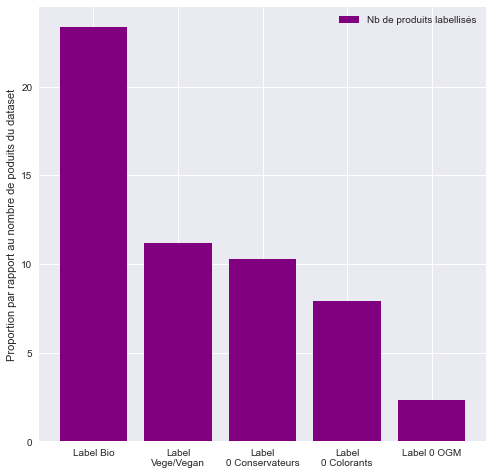

In [86]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.bar(list(range(1, len(qtty_label)+1)), percent_label, color='purple', label='Nb de produits labellisés')
plt.xticks(list(range(1, len(qtty_label)+1)), ['Label Bio', 'Label\nVege/Vegan', 'Label\n0 Conservateurs', 'Label\n0 Colorants', 'Label 0 OGM'])
plt.ylabel('Proportion par rapport au nombre de poduits du dataset (%)')
plt.legend()
plt.show()

<a id='univ_2'></a>
### Categories

In [53]:
data_filtre.categories_en.describe()

count                                               92328
unique                                              24127
top       Snacks,Sweet snacks,Biscuits and cakes,Biscuits
freq                                                  810
Name: categories_en, dtype: object

Même configuration : forte cardinalité d'une variable qualitative

In [54]:
data_filtre.categories_en.value_counts().head(10)

Snacks,Sweet snacks,Biscuits and cakes,Biscuits                                                                        810
Meats,Prepared meats,Hams,White hams                                                                                   697
Snacks,Sweet snacks,Chocolates,Dark chocolates                                                                         623
Snacks,Sweet snacks,Confectioneries,Candies                                                                            375
Dairies,Fermented foods,Fermented milk products,Yogurts                                                                372
Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Chocolate biscuits                                                     358
Snacks,Salty snacks,Appetizers,Crackers                                                                                346
Snacks,Sweet snacks,Chocolates,Milk chocolates                                                                         344
Dairies,Fermente

Dans le cadre du projet d'application, cette colonne nous servira a proposer un produit de la même catégorie. Il faudra également la rassembler en moins de cardinalités

On peut aussi se servir de cette colonne pour un analyse spécifique d'une catégorie d'aliments. par exemple pour voir si le nutriscore est meilleur sans plastique pour certaines catégories.

<a id='univ_3'></a>
### Packaging

In [55]:
data_filtre.packaging_tags.describe()

count                92328
unique               18443
top       sachet,plastique
freq                  4878
Name: packaging_tags, dtype: object

Même configuration : forte cardinalité d'une variable qualitative

In [56]:
data_filtre.packaging_tags.value_counts().head(10)

sachet,plastique       4878
plastique              2626
kunststoff             2017
carton                 1963
frais,plastique        1611
barquette,plastique    1460
frais                  1454
carton,plastique       1224
plastic                1189
sachet                 1155
Name: packaging_tags, dtype: int64

Pour notre étude il est essentiel de réduire la cardinalité de cette donnée.

<a id='univ_4'></a>
### Additifs

In [57]:
data_filtre.additives_n.describe()

count    92328.000000
mean         1.575221
std          2.239675
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         30.000000
Name: additives_n, dtype: float64

In [58]:
data_filtre.additives_n.head(5)

323    2.0
346    4.0
384    0.0
385    1.0
393    3.0
Name: additives_n, dtype: float64

Cette variable est une variable quantitative visiblement entière

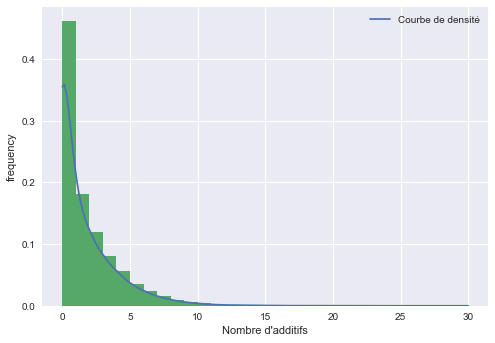

In [59]:
plot_histo(data_filtre.additives_n, bins=30, xlabel="Nombre d'additifs")

J'aimerais utiliser cette variable pour tester la correlation entre le nombre d'additifs et la présence de plastique dans l'emballage

<a id='univ_5'></a>
### Huile de palme

In [60]:
data_filtre.ingredients_from_palm_oil_n.describe()

count    92328.000000
mean         0.037984
std          0.193748
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: ingredients_from_palm_oil_n, dtype: float64

In [61]:
data_filtre.ingredients_from_palm_oil_n.value_counts()

0.0    88867
1.0     3415
2.0       46
Name: ingredients_from_palm_oil_n, dtype: int64

<a id='univ_6'></a>
### Graisse saturée

In [62]:
data_filtre['saturated-fat_100g'].describe()

count    92328.000000
mean         5.480784
std          8.357085
min          0.000000
25%          0.350000
50%          2.000000
75%          7.700000
max        140.000000
Name: saturated-fat_100g, dtype: float64

Cette variable quantitative donne le nombre de grammes de graisse saturée pour 100g de produit. Il n'est donc pas logique que certains produits aient une valeur de plus de 100.
Regardons ces valeurs

In [63]:
data_filtre[data_filtre['saturated-fat_100g'] >= 100][['product_name', 'nutriscore_grade', 'quantity', 'saturated-fat_100g', 'serving_size', 'ingredients_text']]

,product_name,nutriscore_grade,quantity,saturated-fat_100g,serving_size,ingredients_text
652577,Palets dorés noix de coco,e,125 g,120.0,23 g,"Farine de ble 50%, sucre, noix de coco 8,4%, h..."
915679,Virgin coconuts oil,d,380 ml,100.0,NaN,Noix de coco bio.
1212389,Kokosöl BIO,e,182g,100.0,NaN,Bio Kokosfett (Sri Lanka). Kokosfett: Fairtrad...
1353590,Aceite de oliva virgen extra &quot;Esencia And...,c,10 ml,140.0,10 ml,Aceite de oliva virgen extra.


Bien que surprenant à première vue, ces outliers n'en sont peut etre pas étant donné que ce sont en fait des huiles liquides. Je suspecte que la données saturated fat soit ici une donnée en ml et que le taux de passage ml-g soit approximatif.
Seul le premier semble suspect d'autent qu'il possède 50% de farine. Je vais donc le supprimer

In [64]:
data_filtre = data_filtre.drop([652577])

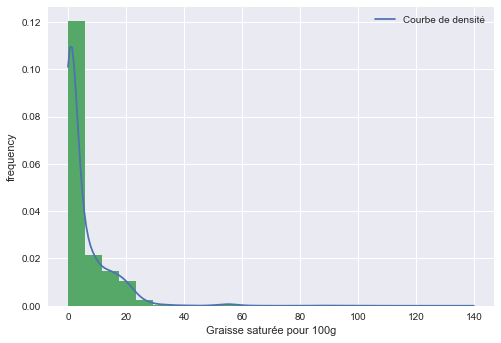

In [65]:
plot_histo(data_filtre['saturated-fat_100g'], bins=24, xlabel="Graisse saturée pour 100g")

<a id='univ_7'></a>
### Nutriscore (numérique)

In [66]:
data_filtre.nutriscore_score.describe()

count    92327.000000
mean         8.115438
std          9.061855
min        -15.000000
25%          1.000000
50%          7.000000
75%         15.000000
max         36.000000
Name: nutriscore_score, dtype: float64

C'est une variable quantitative sur la qualité des aliments

Voici la documentation:

<img src="img/nutriscore.png" style="height:250px">

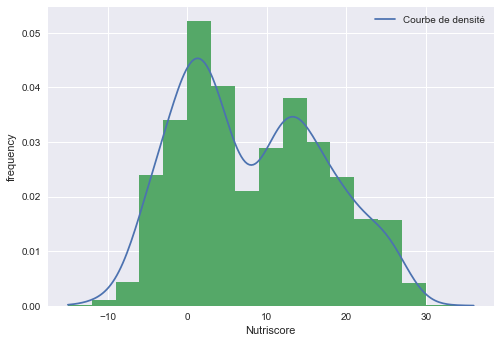

In [67]:
plot_histo(data_filtre['nutriscore_score'], xlabel="Nutriscore")

Mesure de la symetrie avec Skewness : 

In [68]:
data_filtre.nutriscore_score.skew()

0.26514023697425426

On voit que la distribution est quasi symétrique avec un léger décalage à gauche

<a id='univ_8'></a>
### Nutriscore (grade)

In [69]:
data_filtre.nutriscore_grade.describe()

count     92327
unique        5
top           d
freq      24722
Name: nutriscore_grade, dtype: object

In [70]:
data_filtre.nutriscore_grade.unique()

array(['b', 'e', 'd', 'c', 'a'], dtype=object)

In [71]:
data_filtre.nutriscore_grade.value_counts()

d    24722
c    20149
a    17401
e    15942
b    14113
Name: nutriscore_grade, dtype: int64

Cette note connue du grand public est une note de A à E (A étant la meilleure et E la moins bonne). C'est donc une variable qualitative ordonnée. On peut la traiter comme une variable quantitative

In [123]:
data_filtre['nutriscore_grade_num'] = data_filtre.nutriscore_grade.replace({'a':4, 'b':3, 'c':2, 'd':1, 'e':0})

In [124]:
data_pie_nutriscore = data_filtre['nutriscore_grade_num'].value_counts().sort_index()

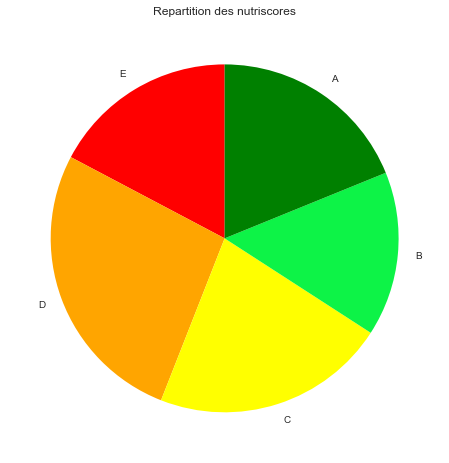

In [125]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.title("Repartition des nutriscores")
plt.pie(data_pie_nutriscore, labels=['E', 'D', 'C', 'B', 'A'], colors=['red','orange','yellow', '#0DF347', 'green'], startangle=90)
plt.show()

No handles with labels found to put in legend.


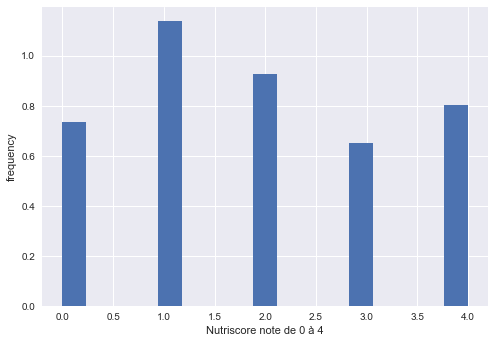

In [126]:
plot_histo(data_filtre['nutriscore_grade_num'], plot_density=False, xlabel='Nutriscore note de 0 à 4')

In [127]:
data_filtre['nutriscore_grade_num'].describe()

count    92327.000000
mean         1.916698
std          1.363183
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: nutriscore_grade_num, dtype: float64

In [128]:
data_filtre['nutriscore_grade_num'].skew()

0.18810225317894622

In [129]:
data_filtre['nutriscore_grade_num'].kurtosis()

-1.1812695990028848

La repartition n'est pas uniforme mais on peut quand même faire l'approximation qu'elle l'est au regard de l'écart interquartile, de kurtosis et de skewness

## 1: Analyse bivariée entre le type d'emaballage et le nutriscore_score

In [118]:
X = "has_plastic" # qualitative
Y = "nutriscore_score" # quantitative

In [119]:
echantillon_1 = data_filtre[['nutriscore_score', 'has_plastic']]

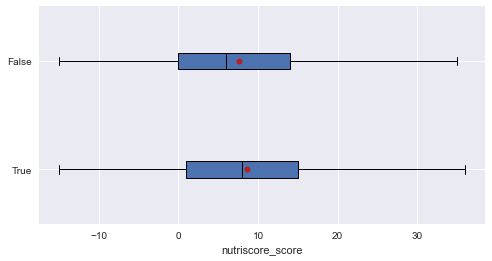

In [122]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_1[echantillon_1[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.show()

In [149]:
X = "has_plastic" # qualitative
Y = "nutriscore_grade_num" # quantitative
echantillon_2 = data_filtre[[Y, X]]

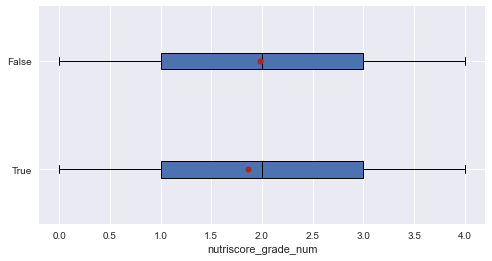

In [150]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_2[echantillon_2[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel(Y)
plt.show()

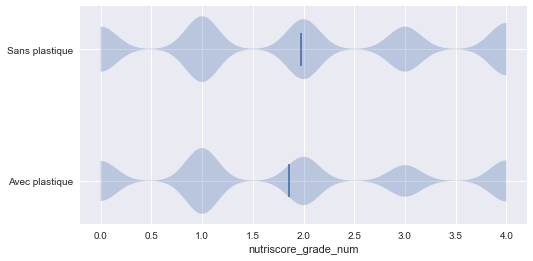

In [151]:
modalites = [True, False]
groupes = []
for m in modalites:
    groupes.append(echantillon_2[echantillon_2[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(8,4))
plt.style.use('seaborn')
plt.violinplot(groupes, vert=False, showmeans=True, showextrema=False)
plt.xlabel(Y)
plt.yticks([1,2], ['Avec plastique', 'Sans plastique'])
plt.show()

## 2: Analyse bivariée entre le type d'emaballage et le nutriscore_grade

## Simplification de la données "packaging_tags"

packaging_tags a une trop forte cardinalité

In [81]:
modalities_raw = data_filtre["packaging_tags"].unique()

In [82]:
len(modalities_raw)

18442

J'aimerais le limiter à moins de modalités

In [89]:
modalities_raw[:10]

array(['carton,plastique', 'sachet', 'pot-en-verre,verre',
       'canette,metal', 'sachet,plastique', 'carton', '21-pap', 'papier',
       'squeezer,plastique', 'glas'], dtype=object)

Par exemple à terme il serait interessant d'avoir ce genre de modalités

In [84]:
modalities_simple = ["plastic", "glass", 'cardboard', 'metal', 'paper', ]

## 3: Analyse bivariée entre le type d'emaballage et le nutriscore_grade
### Avec seulement deux catégories plastique/pas de plastique

In [154]:
plastic_test = lambda x : bool(re.search(r'plast', x)) or bool(re.search(r'kunstoff', x))

In [155]:
data_filtre["has_plastic"] = data_filtre['packaging_tags'].map(plastic_test)

In [156]:
data_filtre.has_plastic.value_counts()

True     47079
False    45248
Name: has_plastic, dtype: int64

In [157]:
X = "nutriscore_grade"
Y = "has_plastic"

echantillon_3 = data_filtre[['nutriscore_grade', 'has_plastic']]
cont = echantillon_3[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len ,margins=True,margins_name="Total")

In [158]:
cont['Freq_False'] = cont.loc[:,0] / cont.Total * 100

In [159]:
cont

has_plastic,False,True,Total,Freq_False
nutriscore_grade,,,,
a,8861,8540,17401,50.922361
b,7577,6536,14113,53.688089
c,10104,10045,20149,50.146409
d,11080,13642,24722,44.818380
e,7626,8316,15942,47.835905
Total,45248,47079,92327,49.008416


In [ ]:
# allemand_count = 0
# for mod in modalities_raw:
#     pattern = r'plast'
#     match = re.search(pattern, mod)
#     if match:
# #         print(mod)
#         pass
#     else:
#         pattern = r'kunststoff'
#         match = re.search(pattern, mod)
#         if match:
#             print(mod)
#             allemand_count += 1
# print(allemand_count)